In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, SimpleRNN, GRU


# 폰트지정
plt.rcParams['font.family'] = 'Malgun Gothic'

# 마이너스 부호 깨짐 지정
plt.rcParams['axes.unicode_minus'] = False

# 숫자가 지수표현식으로 나올 때 지정
pd.options.display.float_format = '{:.2f}'.format


# 데이터 로드 및 전처리
file_path = "dataset/seoul_pm10.csv"  # 데이터 파일 경로
df = pd.read_csv(file_path, encoding='cp949')
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values('date')


In [3]:
# 강남구 데이터만 선택하고 NaN 처리
gangnam_data = df[df['area'] == '용산구'][['date', 'pm10']].set_index('date')
gangnam_data = gangnam_data.fillna(method='ffill').fillna(method='bfill')  # NaN 처리


C:\Users\human-28\AppData\Local\Temp\ipykernel_2464\3319731181.py:3: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  gangnam_data = gangnam_data.fillna(method='ffill').fillna(method='bfill')  # NaN 처리


In [4]:
# 이상치 제거 (선택사항)
Q1 = gangnam_data['pm10'].quantile(0.25)
Q3 = gangnam_data['pm10'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
gangnam_data = gangnam_data[(gangnam_data['pm10'] >= lower_bound) & (gangnam_data['pm10'] <= upper_bound)]

In [5]:
# 데이터 정규화
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(gangnam_data)


In [6]:
# 시계열 데이터셋 생성 함수
def create_dataset(data, time_steps):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:(i + time_steps), 0])
        y.append(data[i + time_steps, 0])
    return np.array(X), np.array(y)

In [7]:
# time_steps 정의
time_steps = 24  # 24시간 데이터로 다음 시간 예측

# 데이터셋 생성
X, y = create_dataset(scaled_data, time_steps)

In [8]:
# 학습/테스트 데이터 분할
train_size = int(len(X) * 0.8) #8대2 비율
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [9]:
# 데이터 reshape (samples, time_steps, features)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [10]:
# LSTM 모델 생성
model = Sequential([
    LSTM(50, activation='relu', input_shape=(time_steps, 1)),
    Dense(1)
])

c:\HJY310\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [11]:
model.compile(optimizer='adam', loss='mse')

In [12]:
# 모델 학습
history = model.fit(X_train, y_train, 
                   epochs=50, 
                   batch_size=32,
                   validation_split=0.1,
                   verbose=1)

Epoch 1/50
189/189 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0689 - val_loss: 0.0103
Epoch 2/50
189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0097 - val_loss: 0.0081
Epoch 3/50
189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0072 - val_loss: 0.0066
Epoch 4/50
189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0060 - val_loss: 0.0056
Epoch 5/50
189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0049 - val_loss: 0.0047
Epoch 6/50
189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0049 - val_loss: 0.0047
Epoch 7/50
189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0045 - val_loss: 0.0043
Epoch 8/50
189/189 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0049 - val_loss: 0.0042
Epoch 9/50
189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0046 - val_loss: 0.0042
Epoch 10/50
189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0046 - val_loss: 0.0042
Epoch 11/50
189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0046 - val_loss: 0.0045
Epoch 12/50
189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step

In [13]:
# 예측
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

210/210 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


In [14]:
# 예측값 역정규화
train_predict = scaler.inverse_transform(train_predict)
y_train_inv = scaler.inverse_transform([y_train])
test_predict = scaler.inverse_transform(test_predict)
y_test_inv = scaler.inverse_transform([y_test])

In [15]:
# 마지막 24시간 데이터로 미래 예측하기
last_24_hours = scaled_data[-time_steps:]  # 마지막 24시간 데이터
last_24_hours = last_24_hours.reshape(1, time_steps, 1)  # 모델 입력 형태로 변환

In [16]:
# 다음 7일(168시간) 예측
n_future = 168  # 예측하고 싶은 시간
future_predictions = []

In [17]:
current_batch = last_24_hours
for i in range(n_future):
    # 다음 값 예측
    current_pred = model.predict(current_batch)[0]
    future_predictions.append(current_pred)
    
    # 다음 예측을 위해 입력 데이터 업데이트
    current_batch = np.roll(current_batch, -1)
    current_batch[0, -1, 0] = current_pred

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


C:\Users\human-28\AppData\Local\Temp\ipykernel_2464\1610009748.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  current_batch[0, -1, 0] = current_pred


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━

In [18]:
# 예측값 역정규화
future_predictions = np.array(future_predictions)
future_predictions = scaler.inverse_transform(future_predictions.reshape(-1, 1))

In [19]:
# 미래 날짜 생성
last_date = gangnam_data.index[-1]
future_dates = pd.date_range(start=last_date, periods=n_future+1, freq='H')[1:]

C:\Users\human-28\AppData\Local\Temp\ipykernel_2464\2903204725.py:3: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  future_dates = pd.date_range(start=last_date, periods=n_future+1, freq='H')[1:]


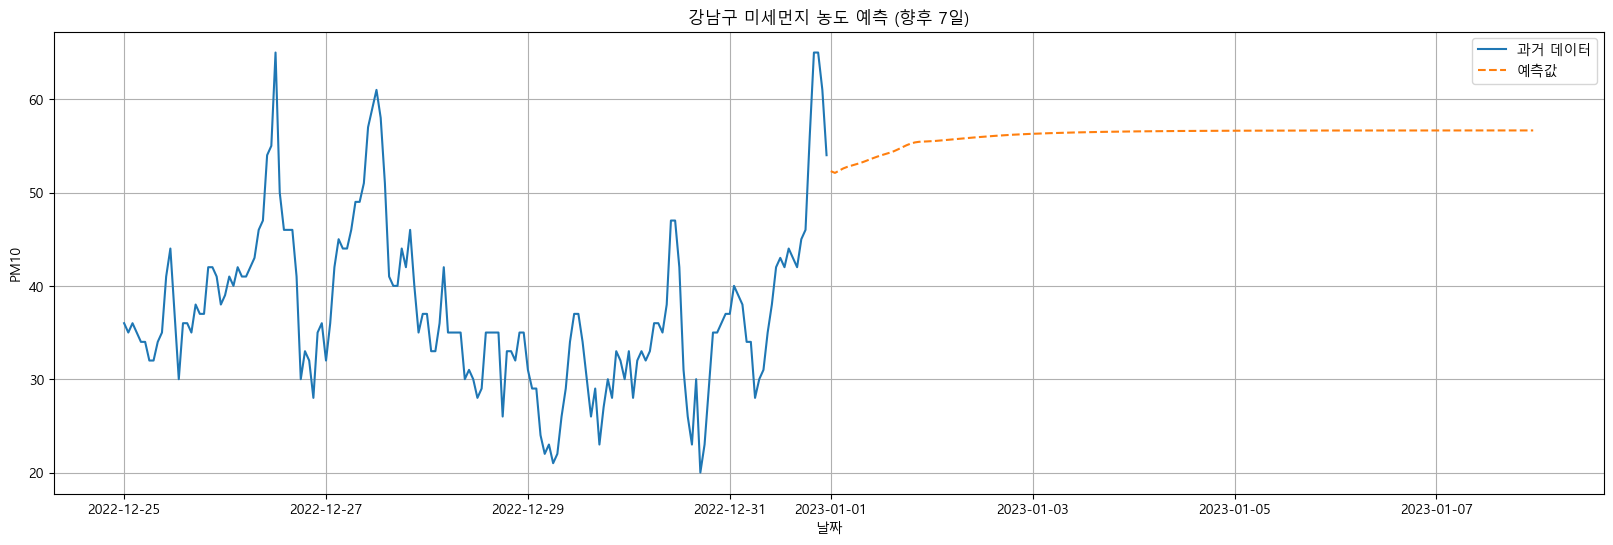

In [20]:
# 결과 시각화
plt.figure(figsize=(20,6))
plt.plot(gangnam_data.index[-168:], gangnam_data['pm10'].iloc[-168:], label='과거 데이터')
plt.plot(future_dates, future_predictions, label='예측값', linestyle='--')
plt.title('강남구 미세먼지 농도 예측 (향후 7일)')
plt.xlabel('날짜')
plt.ylabel('PM10')
plt.legend()
plt.grid(True)
plt.show()

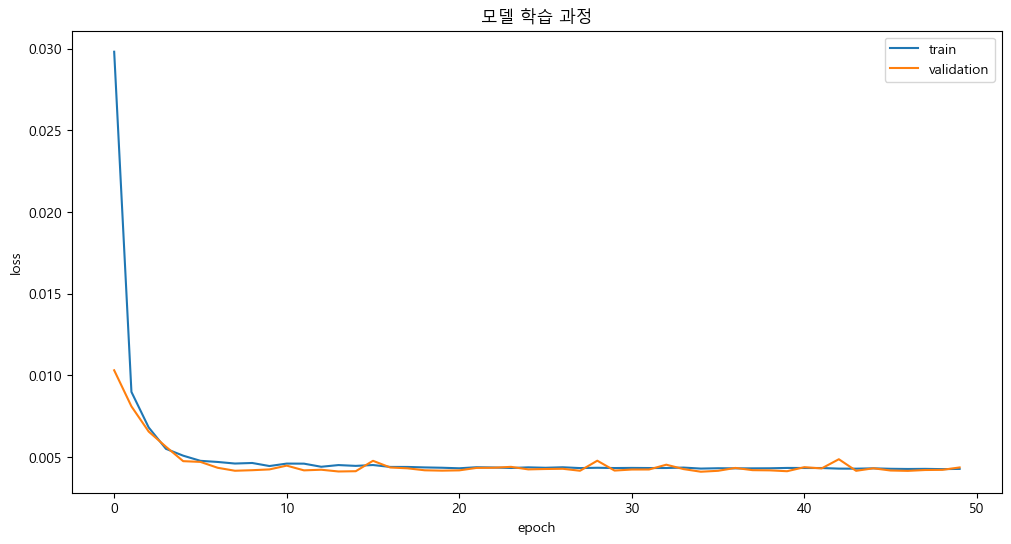

In [21]:
# 학습 과정 시각화
plt.figure(figsize=(12,6))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.title('모델 학습 과정')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()